In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import  Counter
import nltk
import pickle
import string


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Importing Dataset
df = pd.read_csv("/content/spam.csv", encoding="latin-1")
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
# Dataset with required features only
df = pd.read_csv("/content/spam.csv", encoding="latin-1", usecols=["v1","v2"])

In [4]:
df.sample(5)

,v1,v2
3716,ham,I'm gonna rip out my uterus.
734,ham,Leaving to qatar tonite in search of an opport...
3333,ham,"That's fine, have him give me a call if he kno..."
3655,ham,Oh really?? Did you make it on air? What's you...
3692,ham,I was about to do it when i texted. I finished...


In [5]:
# Rename the Features
df.rename(columns={"v1": "output","v2": "input"}, inplace = True)


In [6]:
df.sample(3)

,output,input
5425,ham,Otherwise had part time job na-tuition..
5552,ham,Have a safe trip to Nigeria. Wish you happines...
4030,ham,"Sorry vikky, i'm Watching olave mandara movie ..."


In [7]:
# Encoding Target Feature
le = LabelEncoder()
df["output"] = le.fit_transform(df["output"])

In [8]:
df.sample(1)

,output,input
327,0,"I'd say that's a good sign but, well, you know..."


In [9]:
# Shape of the Dataset
df.shape

(5572, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   output  5572 non-null   int64 
 1   input   5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [11]:
# Check Null Values
df.isnull().sum()

output    0
input     0
dtype: int64

In [12]:
# Check Duplicate Values
df.duplicated().sum()

403

In [13]:
# Drop Duplicates
df = df.drop_duplicates(keep="first")

In [14]:
df.shape

(5169, 2)

In [15]:
df.head()

,output,input
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# Ham & Spam Counts
df["output"].value_counts()

0    4516
1     653
Name: output, dtype: int64

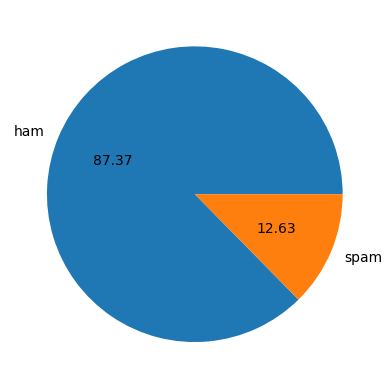

In [17]:
plt.pie(df["output"].value_counts(),autopct = "%.2f", labels=['ham','spam'])
plt.show()

In [18]:
# Total No. of Characters in Data
df["characters"] = df["input"].apply(len)

In [19]:
# Total No. of Words in Data
df["word"] = df["input"].apply(lambda x:len( nltk.word_tokenize(x)))

In [20]:
# Total No. of Sentence
df["sentence"] = df["input"].apply(lambda x:len(nltk.sent_tokenize(x)))

In [21]:
df.head()

,output,input,characters,word,sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [22]:
# Statistical Analysis of new features
df[["characters","word", "sentence"]].describe()

,characters,word,sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [23]:
# Statistical Analysis for HAM Data
df[df["output"]==0][["characters","word", "sentence"]].describe()

,characters,word,sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [24]:
# Statistical Analysis for SPAM Data
df[df["output"] ==1][["characters","word", "sentence"]].describe()

,characters,word,sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


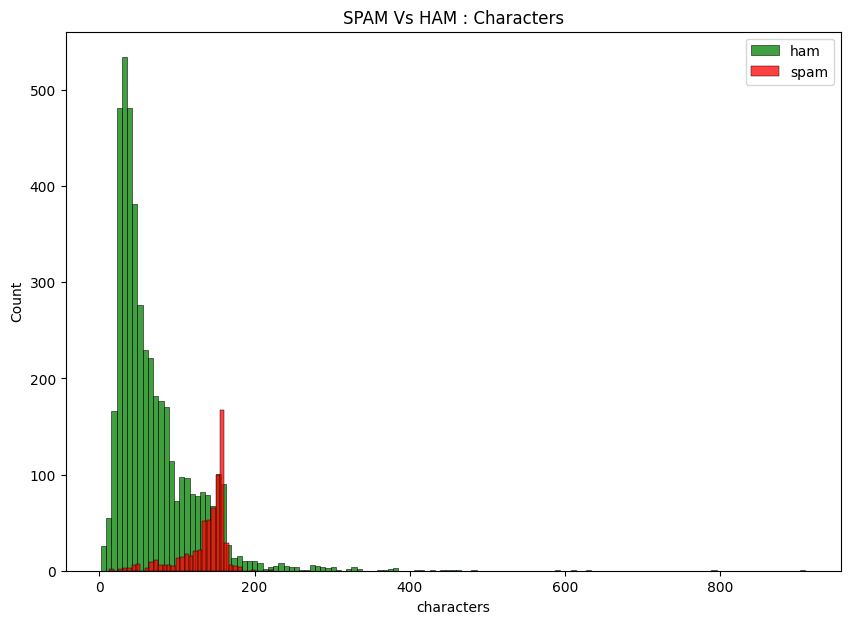

In [25]:
plt.figure(figsize=(10,7))
sns.histplot(df[df["output"]==0]["characters"],label= "ham",color="green")
sns.histplot(df[df["output"]==1]["characters"],label= "spam",color = "red")
plt.title("SPAM Vs HAM : Characters")
plt.legend()
plt.show()

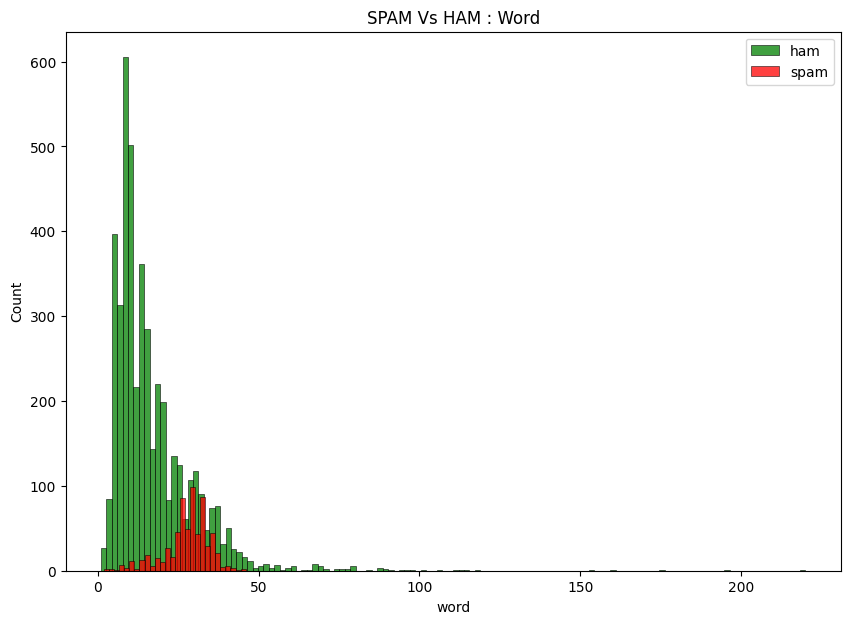

In [26]:
plt.figure(figsize=(10,7))
sns.histplot(df[df["output"]==0]["word"],label= "ham",color="green")
sns.histplot(df[df["output"]==1]["word"],label= "spam",color = "red")
plt.title("SPAM Vs HAM : Word")
plt.legend()
plt.show()

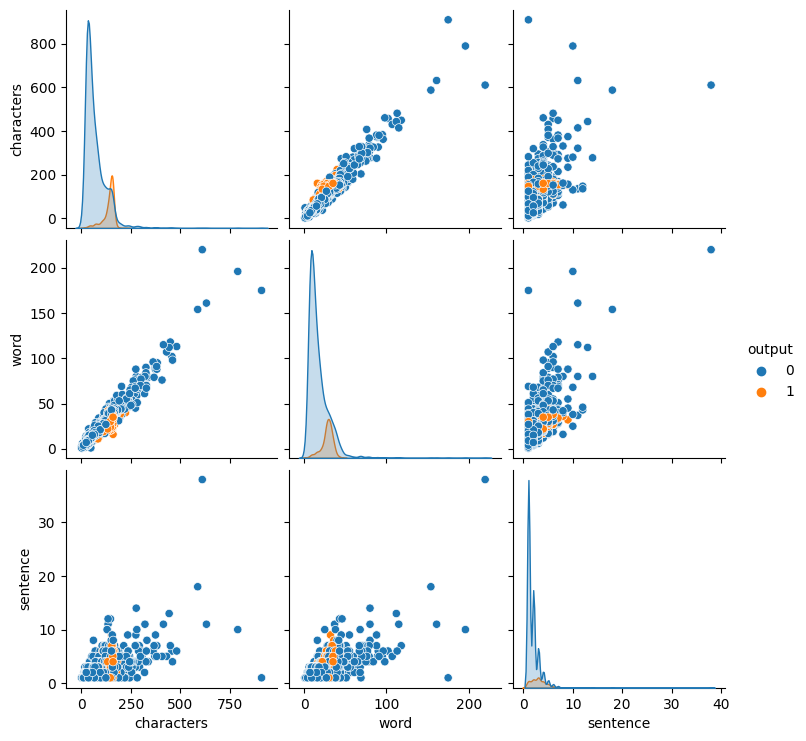

In [27]:
sns.pairplot(df,hue="output")

In [28]:
# Correlations between features
df.corr()

,output,characters,word,sentence
output,1.000000,0.384717,0.262912,0.263939
characters,0.384717,1.000000,0.965760,0.624139
word,0.262912,0.965760,1.000000,0.679971
sentence,0.263939,0.624139,0.679971,1.000000


<Axes: >

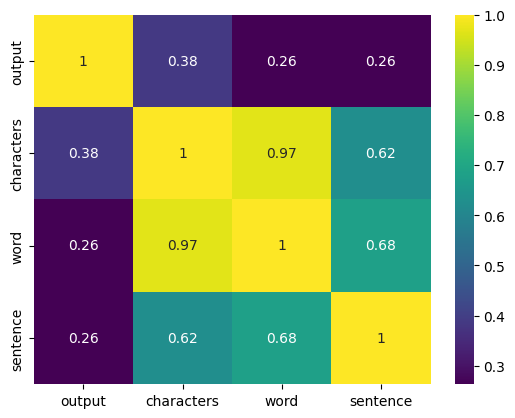

In [29]:
sns.heatmap(df.corr(),annot=True,cmap="viridis")


In [30]:
# Intilizing Porter Stemmer Class
ps = PorterStemmer()

In [31]:
# This Function helps to get Ready!!!

def data(text):
    text = text.lower()               #  Converts Text in Lower Case
    text = nltk.word_tokenize(text)   #  Breaks Text in Words

    y = []
    for i in text:
        if i.isalnum():               #  Removing Special Characters
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:                    #  Removing Stopwords and Punctuation
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:                    #  Porter Stemmer removing unwanted words
        y.append(ps.stem(i))

    return " ".join(y)

In [32]:
# Checking data function
data("shree ram 🚩 and shree mahakaleshawar 🔱 are everything for me")


'shree ram shree mahakaleshawar everyth'

In [33]:
df.sample(2)

,output,input,characters,word,sentence
3814,0,"Not yet chikku..k, then wat abt tht guy did he...",82,20,1
2022,1,U can WIN å£100 of Music Gift Vouchers every w...,158,23,1


In [34]:
# Transforming dataset using the "data" function in new column "new_data"
df["new_data"] = df["input"].apply(data)


In [35]:
df.sample(5)

,output,input,characters,word,sentence,new_data
302,0,Oh and by the way you do have more food in you...,91,23,2,oh way food fridg want go meal tonight
738,0,Wish i were with you now!,25,7,1,wish
2747,0,Ya had just now.onion roast.,28,6,1,ya roast
2702,0,"Omw back to tampa from west palm, you hear wha...",57,13,1,omw back tampa west palm hear happen
2695,0,And whenever you and i see we can still hook u...,52,13,1,whenev see still hook


In [36]:
wc = WordCloud(
    background_color=None,
    width=800,
    height=400
)

In [37]:
# Wordcloud for SPAM
spam_wc = wc.generate(df[df["output"] ==1]["new_data"].str.cat(sep=" "))

# Wordcloud for HAM
ham_wc = wc.generate(df[df["output"] ==0]["new_data"].str.cat(sep=" "))


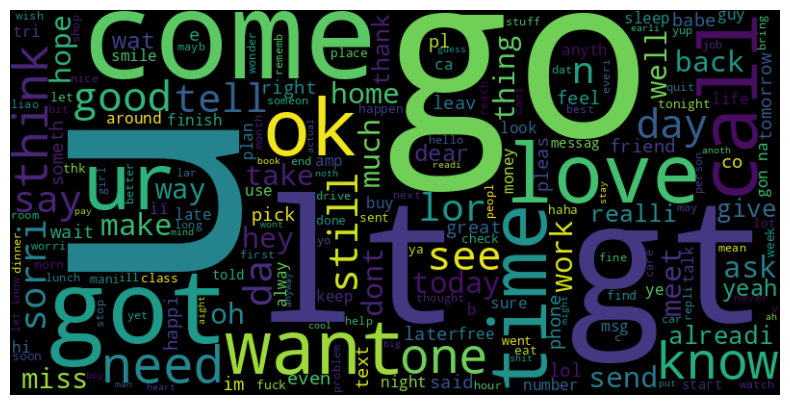

In [38]:
# SPAM
plt.figure(figsize=(10, 5))
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

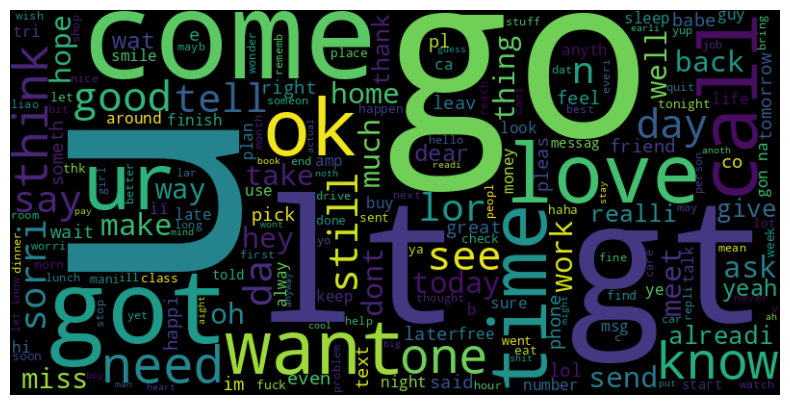

In [39]:
# HAM
plt.figure(figsize=(10, 5))
plt.imshow(ham_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [40]:
# Spliting SPAM Sentences in Words
spam_corpus = []
for msg in df[df["output"]==1]["new_data"].tolist():
    for word in msg.split():
        spam_corpus.append(word)


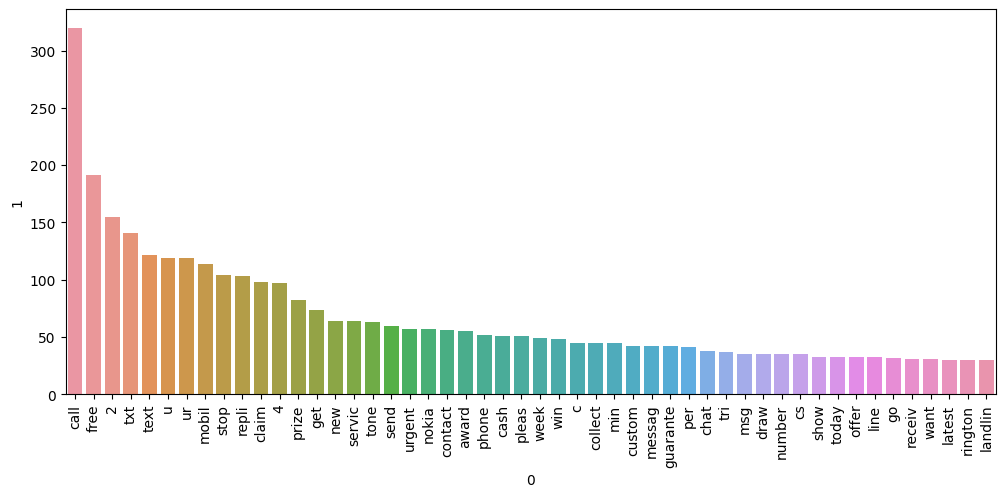

In [41]:
# Top 50 SPAM Words
a=pd.DataFrame(Counter(spam_corpus).most_common(50))[0]
b=pd.DataFrame(Counter(spam_corpus).most_common(50))[1]
plt.figure(figsize=(12,5))
sns.barplot(x= a,y=b)
plt.xticks(rotation=90)

plt.show()

In [42]:
# Spliting HAM Sentences in Words
ham_corpus = []
for msg in df[df['output'] == 0]['new_data'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

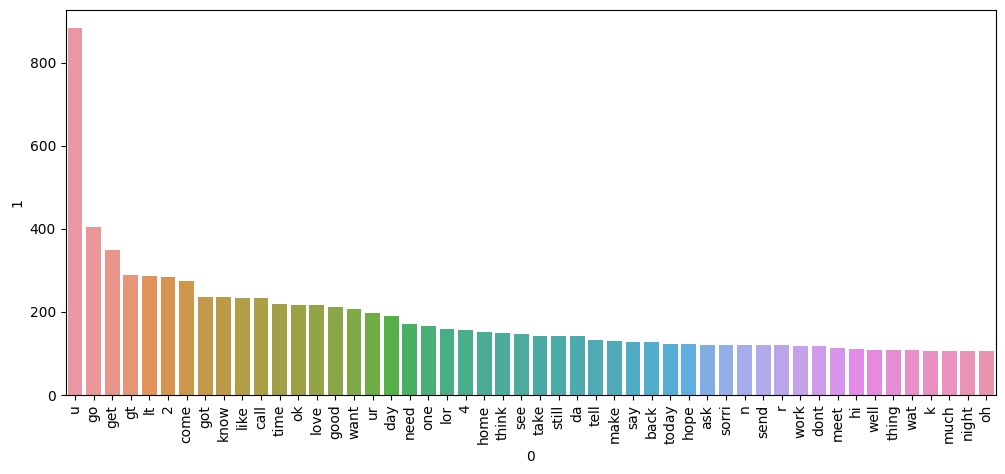

In [43]:
# Top 50 HAM Words
a=pd.DataFrame(Counter(ham_corpus).most_common(50))[0]
b=pd.DataFrame(Counter(ham_corpus).most_common(50))[1]
plt.figure(figsize=(12,5))
sns.barplot(x= a,y=b)
plt.xticks(rotation=90)

plt.show()


In [44]:
# Initilizing TFIDF Vectorizer
tfidv = TfidfVectorizer(max_features=3000)

In [45]:
# Independent Feature
X = tfidv.fit_transform(df["new_data"]).toarray()

In [46]:
# Dependent Feature
y = df["output"].values


In [47]:
# Performing Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [48]:
# Models that are going to be trained
models={
    "Gaussian NB" : GaussianNB(),
    "Multinomial NB" : MultinomialNB(),
    "Bernoulli NB" : BernoulliNB(),
    "Logistic Regression" : LogisticRegression(),
    "SVC" : SVC(),
    "Decision Tree" : DecisionTreeClassifier(),
    "KNN" : KNeighborsClassifier(),
    "Bagging CLF" : BaggingClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "ETC" : ExtraTreesClassifier(),
    "Ada Boost" : AdaBoostClassifier(),
    "Gradient Boost" : GradientBoostingClassifier(),
    "XGB" : XGBClassifier(),
    "XGBRF" : XGBRFClassifier()
}

In [49]:
# Creating a function train each model and calculate/return accuracy and precision
def train_clf (model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)

    return acc, pre

In [50]:
# A FOR loop Calls "traim_clf" for each model and stores accuracy and precision
acc_s=[]
pre_s=[]

for name, model in models.items():
    accuracy, precision = train_clf(model, X_train, y_train, X_test, y_test)

    acc_s.append(accuracy)
    pre_s.append(precision)

In [51]:
# As Precision matter over Accuracy in this Data, Sorting in DESC order of Precision. All Scores of Models

scores_df = pd.DataFrame({"Algorithm": models.keys(),
                          "Accuracy": acc_s,
                         "Precision": pre_s}).sort_values(by="Precision", ascending=False)


In [52]:
scores_df

,Algorithm,Accuracy,Precision
6,KNN,0.916828,1.000000
4,SVC,0.974855,0.991736
8,Random Forest,0.973888,0.991667
1,Multinomial NB,0.972921,0.991597
9,ETC,0.978723,0.976744
11,Gradient Boost,0.959381,0.963964
2,Bernoulli NB,0.972921,0.960630
3,Logistic Regression,0.958414,0.947368
12,XGB,0.970986,0.938931
13,XGBRF,0.944874,0.879310


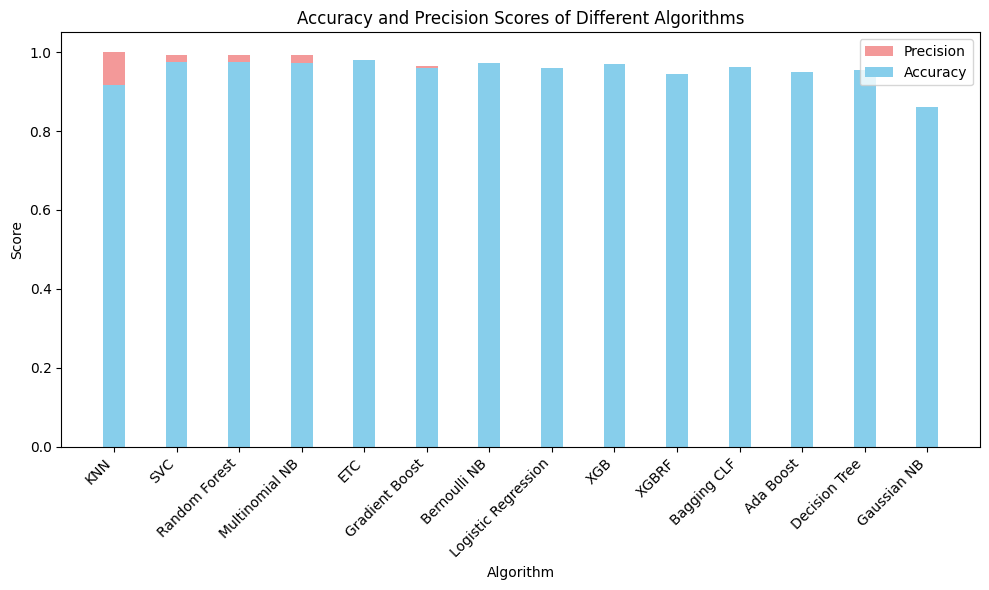

In [53]:
# Graph Accuracy and Precision

plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(scores_df["Algorithm"], scores_df["Precision"], width=bar_width, label="Precision", color='lightcoral', alpha=0.8)
plt.bar(scores_df["Algorithm"], scores_df["Accuracy"], width=bar_width, label="Accuracy", color='skyblue')
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.title("Accuracy and Precision Scores of Different Algorithms")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
# Hence Multinomial Naïve Bayes give excellent precision and accuracy scores.
# According to me MNB is sutaible for Model

mnb=MultinomialNB()
mnb.fit(X_train, y_train)


MultinomialNB()